In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers, models, Input

from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow_datasets as tfds


In [12]:
dataset, info = tfds.load(
    "oxford_iiit_pet",
    with_info=True,
    split=["train", "test"],
    as_supervised=True
)

train_ds, test_ds = dataset
print(info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

In [13]:
def double_conv_block(x, n_filters):

    # Two 3x3 convolutions + ReLU + BatchNorm

    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)

    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)

    x = layers.BatchNormalization()(x)

    return x



def downsample_block(x, n_filters):

    f = double_conv_block(x, n_filters)

    p = layers.MaxPool2D(2)(f)

    return f, p



def upsample_block(x, conv_features, n_filters):

    # Upsample + concatenate skip connection

    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)

    x = layers.concatenate([x, conv_features])

    x = double_conv_block(x, n_filters)

    return x

In [14]:
def build_unet(input_shape=(128, 128, 1)):   # grayscale medical images often 1 channel

    inputs = Input(input_shape)



    # Encoder (downsampling)

    f1, p1 = downsample_block(inputs, 64)

    f2, p2 = downsample_block(p1,    128)

    f3, p3 = downsample_block(p2,    256)

    f4, p4 = downsample_block(p3,    512)



    # Bottleneck

    bottleneck = double_conv_block(p4, 1024)



    # Decoder (upsampling)

    u6 = upsample_block(bottleneck, f4, 512)

    u7 = upsample_block(u6,         f3, 256)

    u8 = upsample_block(u7,         f2, 128)

    u9 = upsample_block(u8,         f1, 64)



    # Output – 1 channel binary mask (sigmoid)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)



    model = models.Model(inputs, outputs, name="U-Net")

    return model



# Create model

model = build_unet(input_shape=(128, 128, 1))

model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[

 Total params: 34,535,745 (131.74 MB)

 Trainable params: 34,523,969 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [15]:
# Compile – Dice loss is very common in medical segmentation

def dice_loss(y_true, y_pred):

    y_true_f = tf.keras.backend.flatten(y_true)

    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)

    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)



model.compile(optimizer=Adam(learning_rate=1e-4),

              loss=dice_loss,

              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])



print("U-Net model ready ✓")

U-Net model ready ✓


In [16]:
# ────────────────────────────────────────────────

#   Step 2: Placeholder data (replace with real medical dataset!)

# ────────────────────────────────────────────────

# In real lab: load images + masks from folder / Kaggle

# Example structure:

# train_images/   train_masks/

# val_images/     val_masks/



# For demo – create dummy data (random shapes)

def generate_dummy_data(num_samples=100, size=128):

    images = np.random.rand(num_samples, size, size, 1).astype(np.float32)

    masks  = (images > 0.6).astype(np.float32)  # simple threshold mask

    return images, masks



x_train, y_train = generate_dummy_data(200)

x_val,   y_val   = generate_dummy_data(40)



print("Dummy data generated (replace with real medical images + masks)")

Dummy data generated (replace with real medical images + masks)


In [17]:
print("\nTraining U-Net...")

history = model.fit(x_train, y_train,

                    validation_data=(x_val, y_val),

                    epochs=20,

                    batch_size=8,

                    verbose=1)


Training U-Net...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 558ms/step - accuracy: 0.6715 - loss: 0.4100 - mean_io_u: 0.2997 - val_accuracy: 0.3999 - val_loss: 0.5292 - val_mean_io_u: 0.3001
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.8910 - loss: 0.1672 - mean_io_u: 0.2998 - val_accuracy: 0.6037 - val_loss: 0.5238 - val_mean_io_u: 0.3001
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.9281 - loss: 0.1258 - mean_io_u: 0.3001 - val_accuracy: 0.7527 - val_loss: 0.5342 - val_mean_io_u: 0.3001
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.9536 - loss: 0.0996 - mean_io_u: 0.2999 - val_accuracy: 0.6387 - val_loss: 0.5574 - val_mean_io_u: 0.3001
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.9685 - loss: 0.0815 - mean_io_u: 0.3000 - val_accuracy: 0.6130 - val_loss: 0.6092 - val_mean_io_u: 0.3001
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.9779 - loss: 0.0678 - mean_io_u: 0.3002 - val_accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


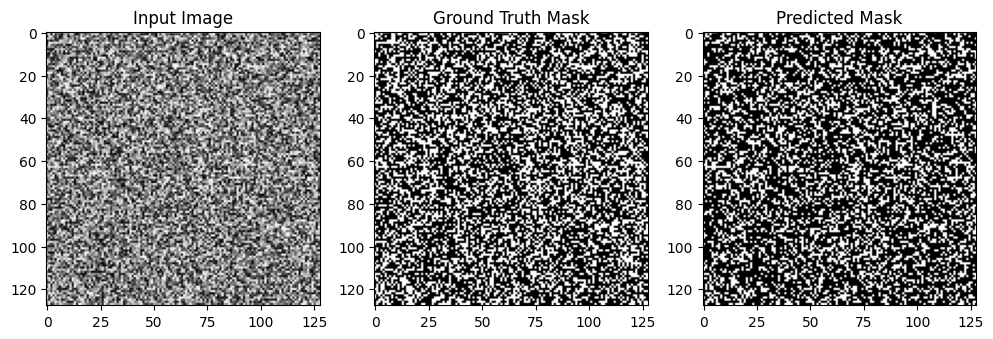

In [20]:
def show_prediction(idx=0):

    pred = model.predict(x_val[idx:idx+1])[0]

    pred = (pred > 0.5).astype(np.float32)



    plt.figure(figsize=(12, 4))

    plt.subplot(1,3,1); plt.imshow(x_val[idx,:,:,0], cmap='gray'); plt.title("Input Image")

    plt.subplot(1,3,2); plt.imshow(y_val[idx,:,:,0], cmap='gray'); plt.title("Ground Truth Mask")

    plt.subplot(1,3,3); plt.imshow(pred[:,:,0], cmap='gray'); plt.title("Predicted Mask")

    plt.show()



show_prediction(10)

# =============================================================================

# Practical 4: Real-time Object Detection with YOLOv8

# Course:            Computer Vision

# Objective:         Use modern YOLO for real-time detection on video / webcam

# Tools:             Python + Ultralytics YOLOv8 (very easy & powerful in 2025–2026)

# Note:              Older Keras YOLOv3 is complex/outdated → YOLOv8 is standard now

# =============================================================================

In [22]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.8 MB/s eta 0:00:00


In [23]:
from ultralytics import YOLO

import cv2

import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow   # only if using Colab

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [24]:
from ultralytics import YOLO
import cv2

# Load model
model = YOLO("yolov8n.pt")

# Input video
input_path = "/content/input_video.mp4"
cap = cv2.VideoCapture(input_path)

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("output_video.mp4", fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, classes=[0,2,3,5,7], conf=0.25)

    annotated_frame = results[0].plot()
    out.write(annotated_frame)

cap.release()
out.release()

print("Output video saved as output_video.mp4")



0: 640x384 4 persons, 62.0ms
Speed: 15.4ms preprocess, 62.0ms inference, 124.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 14.4ms
Speed: 8.1ms preprocess, 14.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 11.8ms
Speed: 3.5ms preprocess, 11.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 10.0ms
Speed: 3.4ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 10.8ms
Speed: 3.4ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 9.7ms
Speed: 3.6ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 10.8ms
Speed: 3.8ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 car, 10.1ms
Speed: 3.8ms preprocess, 10.1ms inference, 2.1ms postprocess per image at